In [1]:
import numpy
import pandas

import matplotlib.pyplot as plt
from matplotlib import animation

from IPython.display import HTML

from scipy.optimize import fsolve

class AstrometricData:
    def __init__(self):
        return
    
    def ClearVar (self, var):
        var = None
    
    def GenerateBackgroundPositions (self, N):
        CartesianPoints = numpy.array(numpy.random.normal(loc=0.0, scale=1.0, size=(N, 3)))
        
        CartesianPoints = self.Normalize(CartesianPoints)
        
        self.BackgroundPositions = CartesianPoints
    
    def ImportBackgroundPositions (self, path, fileEncoding=None, coordSystem=None, radius=None, longitude=None, latitude=None, distanceUnits=None, angleUnits=None):
        data = pandas.read_csv(
            path,
            sep=',',
            delimiter=None,
            header='infer',
            names=None,
            index_col=None,
            usecols=None,
            squeeze=False,
            prefix=None,
            mangle_dupe_cols=True,
            dtype=None,
            engine='python',
            converters=None,
            true_values=None,
            false_values=None,
            skipinitialspace=False,
            skiprows=None,
            nrows=None,
            na_values=None,
            keep_default_na=True,
            na_filter=True,
            verbose=False,
            skip_blank_lines=True,
            parse_dates=False,
            infer_datetime_format=False,
            keep_date_col=False,
            date_parser=None,
            dayfirst=False,
            iterator=False,
            chunksize=None,
            compression='infer',
            thousands=None,
            decimal='.',
            lineterminator=None,
            quotechar='”',
            quoting=0,
            escapechar=None,
            comment=None,
            encoding=fileEncoding,
            dialect=None,
            error_bad_lines=True,
            warn_bad_lines=True,
            skipfooter=0,
            doublequote=True,
            delim_whitespace=False,
            low_memory=True,
            memory_map=False,
            float_precision=None
        )
        
        if coordSystem == "Galactic":
            if not longitude or not latitude:
                self.RaiseError ("You need to specify longitude and latitude columns.")
            else:
                if hasattr(self, 'BackgroundPositions'):
                    self.ClearVar (self.BackgroundPositions)
                
                N = data.shape[0]
                
                self.BackgroundPositions = numpy.array(numpy.zeros((N, 3)))
                
                if radius:
                    self.BackgroundPositions[:, 0] = data[radius]
                else:
                    self.BackgroundPositions[:, 0] = numpy.array(numpy.ones(N))
                    
                self.BackgroundPositions[:, 1] = data[longitude]
                self.BackgroundPositions[:, 2] = data[latitude]
                
                self.CoordinateSystem = coordSystem
                
                if angleUnits == "deg":
                    self.angleUnits = "deg"
                elif angleUnits == "rad":
                    self.angleUnits = "rad"
                    
                if self.angleUnits == "deg":
                    self.BackgroundPositions = self.DegToRad(self.BackgroundPositions)
                    
                self.BackgroundPositions = self.GalacticToGeographic(self.BackgroundPositions)
                self.BackgroundPositions = self.GeographicToSpherical(self.BackgroundPositions)
                self.BackgroundPositions = self.SphericalToCartesian(self.BackgroundPositions)
                
    def ChangeCoordinateSystem (self, target):
        print (target)
    
    def CartesianToSpherical (self, CartesianPoints):
        sphericalPoints = numpy.array(numpy.zeros(CartesianPoints.shape))
        xyRadiusSq = CartesianPoints[:, 0]**2 + CartesianPoints[:, 1]**2
        
        sphericalPoints[:, 0] = numpy.sqrt(xyRadiusSq + CartesianPoints[:, 2]**2)
        sphericalPoints[:, 1] = numpy.arctan2(numpy.sqrt(xyRadiusSq), CartesianPoints[:, 2])
        sphericalPoints[:, 2] = numpy.arctan2(CartesianPoints[:, 1], CartesianPoints[:, 0])
        sphericalPoints[:, 2] = [phi if phi >= 0.0 else phi + 2 * numpy.pi for phi in sphericalPoints[:, 2]]
        
        return sphericalPoints
    
    def SphericalToCartesian (self, sphericalPoints):
        CartesianPoints = numpy.array(numpy.zeros(sphericalPoints.shape))
        
        CartesianPoints[:, 0] = numpy.multiply(sphericalPoints[:, 0], numpy.multiply(numpy.sin(sphericalPoints[:, 1]), numpy.cos(sphericalPoints[:, 2])))
        CartesianPoints[:, 1] = numpy.multiply(sphericalPoints[:, 0], numpy.multiply(numpy.sin(sphericalPoints[:, 1]), numpy.sin(sphericalPoints[:, 2])))
        CartesianPoints[:, 2] = numpy.multiply(sphericalPoints[:, 0], numpy.cos(sphericalPoints[:, 1]))
        
        return CartesianPoints
    
    def SphericalToGeographic (self, sphericalPoints):
        geographicPoints = numpy.array(numpy.zeros(sphericalPoints.shape))
        
        geographicPoints[:, 0] = sphericalPoints[:, 0]
        geographicPoints[:, 1] = sphericalPoints[:, 2] - numpy.pi
        geographicPoints[:, 2] = numpy.pi/2 - sphericalPoints[:, 1]
        
        return geographicPoints
    
    def GalacticToGeographic (self, galacticPoints):
        geographicPoints = numpy.array(numpy.zeros(galacticPoints.shape))
        
        geographicPoints[:, 0] = galacticPoints[:, 0]
        
        geographicPoints[:, 1] = - galacticPoints[:, 1]
        geographicPoints[:, 1] = [long + 2 * numpy.pi if long < - numpy.pi else long for long in geographicPoints[:, 1]]
        
        geographicPoints[:, 2] = galacticPoints[:, 2]
        
        return geographicPoints
    
    def GeographicToSpherical (self, geographicPoints):
        sphericalPoints = numpy.array(numpy.zeros(geographicPoints.shape))
        
        sphericalPoints[:, 0] = geographicPoints[:, 0]
        sphericalPoints[:, 1] = numpy.pi/2 - geographicPoints[:, 2]
        sphericalPoints[:, 2] = geographicPoints[:, 1] + numpy.pi
        
        return sphericalPoints
    
    def MollweideFunc (self, latitude, epsilon):
        MollweideFunc = lambda alpha : 2 * alpha + numpy.sin(2 * alpha) - numpy.pi * latitude
        
        alpha = fsolve(MollweideFunc, latitude)
        
        return alpha[0]
    
    def GeographicToMollweide (self, geographicPoints):
        epsilon = 1e-9
        
        MollweidePoints = numpy.array(numpy.zeros(geographicPoints.shape))
        
        MollweidePoints[:, 0] = geographicPoints[:, 0]
        
        alpha = [self.MollweideFunc(lat, epsilon) if not numpy.isclose(lat, numpy.pi/2, rtol=epsilon, atol=0.0, equal_nan=False) else lat for lat in geographicPoints[:, 2]]

        MollweidePoints[:, 1] = (2 * numpy.sqrt(2) / numpy.pi) * geographicPoints[:, 1] * numpy.cos(alpha)
        MollweidePoints[:, 2] = numpy.sqrt(2) * numpy.sin(alpha)
        
        return MollweidePoints
    
    def RadToDeg (self, polarPoints):
        polarPoints[:, 1:] = numpy.rad2deg(polarPoints[:, 1:])
        
        return polarPoints
    
    def DegToRad (self, polarPoints):
        polarPoints[:, 1:] = numpy.deg2rad(polarPoints[:, 1:])
        
        return polarPoints
    
    def Normalize (self, x):
        norms = numpy.linalg.norm(x, ord=None, axis=-1, keepdims=True)
        
        return numpy.divide(x, norms, out=None, where=True, casting='same_kind', order='K', dtype=None)
        
    def SelectMode (self, mode):
        if mode == "plus":
            return numpy.array([[1, 0, 0], [0, -1, 0], [0, 0, 0]])
        elif mode == "cross":
            return numpy.array([[0, 1, 0], [1, 0, 0], [0, 0, 0]])
        elif mode == "scalar":
            return numpy.array([[1, 0, 0], [0, 1, 0], [0, 0, 0]])
        elif mode == "vector1":
            return numpy.array([[0, 0, 1], [0, 0, 0], [1, 0, 0]])
        elif mode == "vector2":
            return numpy.array([[0, 0, 0], [0, 1, 0], [0, 1, 0]])
        elif mode == "longitudinal":
            return numpy.array([[0, 0, 0], [0, 0, 0], [0, 0, 1]])
        elif mode == "circular":
            return (numpy.array([[1, 0, 0], [0, -1, 0], [0, 0, 0]]) + 
                    numpy.array([[0, 1, 0], [1, 0, 0], [0, 0, 0]]))
        elif mode == "evanescent":
            alpha = 0.5
            kappa = numpy.sqrt(1 + alpha**2)
            
            return (numpy.array([[kappa**2, 0, -1j*alpha*kappa], [0, -1, 0], [-1j*alpha*kappa, 0, -alpha**2]]) + 
                    numpy.array([[0, kappa, 0], [kappa, 0, -1j*alpha], [0, -1j*alpha, 0]]))
        
    def GWDeviation (self, n, q, mode, amp, t, d=None, m=None):
        modeMatrix = self.SelectMode(mode)
        
        if m:
            q = numpy.sqrt(1 - m * m) * q
        
        H = amp * modeMatrix
        
        Hn = numpy.einsum('ik,jk->ji', H, n)
        nHn = numpy.einsum('ji,ji->j', n, Hn).reshape((n.shape[0], 1))
        qn = numpy.einsum('j,ij->i', q, n).reshape((n.shape[0], 1))
        
        if d is None:
            deviation = numpy.real((numpy.divide((n - q) * nHn, (2 * (1 - qn)), out=None, where=True, casting='same_kind', order='K', dtype=None) - 0.5 * Hn) * numpy.exp(- 1j * t))
        else:
            deviation = numpy.real(((numpy.divide(1 + 1j * (2 - qn), d * (1 - qn), out=None, where=True, casting='same_kind', order='K', dtype=None) * (1 - numpy.exp(- 1j * d * (1 - qn)))) * n - (1 + numpy.divide(1j, d * (1 - qn), out=None, where=True, casting='same_kind', order='K', dtype=None) * (1 - numpy.exp(- 1j * d * (1 - qn)))) * q) * numpy.divide(nHn, (2 * (1 - qn)), out=None, where=True, casting='same_kind', order='K', dtype=None) - (0.5 + numpy.divide(1j, d * (1 - qn), out=None, where=True, casting='same_kind', order='K', dtype=None) * (1 - numpy.exp(- 1j * d * (1 - qn)))) * Hn * numpy.exp(- 1j * t))                                                      
        
        return deviation
    
    def GWAstrometricData (self, GWDir, mode, amp, numFrames, dist=None, mass=None):
        self.Frames = []
        
        for t in range(numFrames):
            frame = numpy.array(numpy.zeros(self.BackgroundPositions.shape))

            frame = self.BackgroundPositions + self.GWDeviation (self.BackgroundPositions, GWDir, mode, amp, t, d=dist, m=mass)
            frame = self.Normalize(frame)
                
            self.Frames.append(frame)
            
    def Plot (self):
        fig, ax = plt.subplots(2, 2, sharex=True, figsize=(18, 20), dpi=100)
        fig.subplots_adjust(hspace=0.0, wspace=0.0)
        
        ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
        ax2 = plt.subplot2grid((2, 2), (1, 0))
        ax3 = plt.subplot2grid((2, 2), (1, 1))
        
        ax1.axis('off')
        ax1.tick_params(axis='both', which='major', direction='in', labelbottom='off', labeltop='off', labelleft='off', labelright='off')
        ax1.set_xticks([], minor=False)
        ax1.set_yticks([], minor=False)
        
        ax2.axis('off')
        ax2.tick_params(axis='both', which='major', direction='in', labelbottom='off', labeltop='off', labelleft='off', labelright='off')
        ax2.set_xticks([], minor=False)
        ax2.set_yticks([], minor=False)
        
        ax3.axis('off')
        ax3.tick_params(axis='both', which='major', direction='in', labelbottom='off', labeltop='off', labelleft='off', labelright='off')
        ax3.set_xticks([], minor=False)
        ax3.set_yticks([], minor=False)
        
        ax1.set_aspect('equal')
        ax1.set_xlim([-3.1, 3.1])
        ax1.set_ylim([-1.6, 1.6])
        
        ax2.set_aspect('equal')
        ax2.set_xlim(-1.1, 1.1)
        ax2.set_ylim(-1.1, 1.1)
        
        ax3.set_aspect('equal')
        ax3.set_xlim(-1.1, 1.1)
        ax3.set_ylim(-1.1, 1.1)
        
        northHemisphPts = self.BackgroundPositions[self.BackgroundPositions[:, 2] >= 0]
        southHemisphPts = self.BackgroundPositions[self.BackgroundPositions[:, 2] <= 0]
        
        sky = self.GeographicToMollweide(self.SphericalToGeographic(self.CartesianToSpherical(self.BackgroundPositions)))
        
        ax1.scatter (sky[:, 1], sky[:, 2], marker='.', s=4, color='b')
        ax2.scatter (northHemisphPts[:, 0], northHemisphPts[:, 1], marker='.', s=4.0, color='b')
        ax3.scatter (southHemisphPts[:, 0], southHemisphPts[:, 1], marker='.', s=4.0, color='b')
        
        plt.show()
        
    def Animate (self):
        fig, ax = plt.subplots(2, 2, figsize=(10.0, 10.5), dpi=100)
        fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.0, hspace=0.0)
        
        ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
        ax2 = plt.subplot2grid((2, 2), (1, 0))
        ax3 = plt.subplot2grid((2, 2), (1, 1))
        
        ax1.axis('off')
        ax1.tick_params(axis='both', which='major', direction='in', labelbottom='off', labeltop='off', labelleft='off', labelright='off')
        ax1.set_xticks([], minor=False)
        ax1.set_yticks([], minor=False)
        
        ax2.axis('off')
        ax2.tick_params(axis='both', which='major', direction='in', labelbottom='off', labeltop='off', labelleft='off', labelright='off')
        ax2.set_xticks([], minor=False)
        ax2.set_yticks([], minor=False)
        
        ax3.axis('off')
        ax3.tick_params(axis='both', which='major', direction='in', labelbottom='off', labeltop='off', labelleft='off', labelright='off')
        ax3.set_xticks([], minor=False)
        ax3.set_yticks([], minor=False)
        
        ax1.set_aspect('equal')
        ax1.set_xlim([-3.1, 3.1])
        ax1.set_ylim([-1.6, 1.6])
        
        ax2.set_aspect('equal')
        ax2.set_xlim(-1.1, 1.1)
        ax2.set_ylim(-1.1, 1.1)
        
        ax3.set_aspect('equal')
        ax3.set_xlim(-1.1, 1.1)
        ax3.set_ylim(-1.1, 1.1)
        
        northHemisphPts = self.BackgroundPositions[self.BackgroundPositions[:, 2] >= 0]
        southHemisphPts = self.BackgroundPositions[self.BackgroundPositions[:, 2] <= 0]
        
        sky = self.GeographicToMollweide(self.SphericalToGeographic(self.CartesianToSpherical(self.BackgroundPositions)))
        
        mollweide = ax1.scatter ([], [], marker='.', s=4.0, color='b')
        north = ax2.scatter ([], [], marker='.', s=4.0, color='b')
        south = ax3.scatter ([], [], marker='.', s=4.0, color='b')
        
        def init():
            mollweide.set_offsets(([],[]))
            north.set_offsets(([],[]))
            south.set_offsets(([],[]))
            
            return (mollweide, north, south,)
        
        def PlotFrame(i):
            currentFrame = self.Frames[i][:]
            
            northHemisphPts = currentFrame[currentFrame[:, 2] >= 0]
            southHemisphPts = currentFrame[currentFrame[:, 2] <= 0]
        
            northHemisphPts = [[northHemisphPts[i,0], northHemisphPts[i,1]] for i in range(len(northHemisphPts))]
            southHemisphPts = [[southHemisphPts[i,0], southHemisphPts[i,1]] for i in range(len(southHemisphPts))]
            
            sky = self.GeographicToMollweide(self.SphericalToGeographic(self.CartesianToSpherical(currentFrame)))
            sky = [[sky[i,1], sky[i,2]] for i in range(len(sky))]
            mollweide.set_offsets(sky)
            north.set_offsets(northHemisphPts)
            south.set_offsets(southHemisphPts)
            
            return (mollweide, north, south,)
        
        plt.margins(0)
        self.anim = animation.FuncAnimation(fig, PlotFrame, init_func=init, frames=len(self.Frames), interval=200, blit=False)
        
        Writer = animation.writers['ffmpeg']
        writer = Writer(fps=4, metadata=dict(artist='Me'), bitrate=1800)
        self.anim.save("circ.mp4", writer=writer)
#         HTML(self.anim.to_html5_video())
#         plt.show()

    def RaiseError (self, errorMessage):
        raise ValueError(errorMessage)
        
        

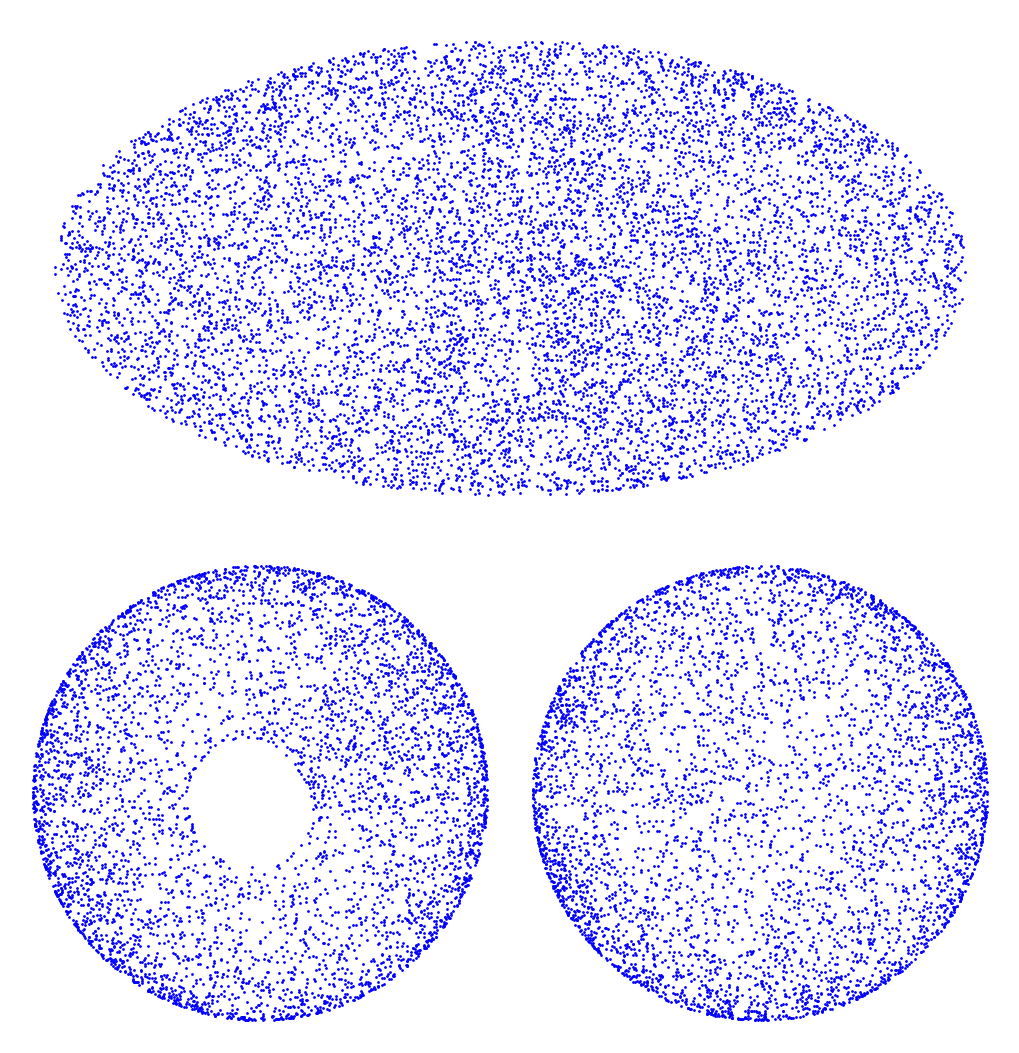

In [2]:
data = AstrometricData()

data.GenerateBackgroundPositions(10000)
data.GWAstrometricData(numpy.array([0, 0, 1]), "evanescent", 0.1, 60, dist=None, mass=0)

data.Animate()